In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:

class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin=xmin
        self.xmax=xmax
        self.num_points=num_points
        self.resolution=(xmax-xmin)/num_points
        self.x_data=np.linspace(xmin,xmax,num_points)
        self.y_true=np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        #Random starting point for batch
        random_start=np.random.rand(batch_size,1)
        
        #Put the random point on the time series
        ts_start=random_start*(self.xmax-self.xmin-(steps*self.resolution)) #Trick to convert any number into a point in the time series
        
        
        batch_ts=ts_start+np.arange(0.0,steps+1) * self.resolution #steps +1 because we are predicting just one tme step ahead
        
        y_batch=np.sin(batch_ts)
        
        #Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1) #Returning the sequence shifted over one time step
        

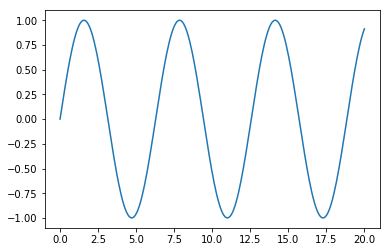

In [3]:
ts_data=TimeSeriesData(250,0,20)
plt.plot(ts_data.x_data,ts_data.y_true)
plt.show()

(11,)


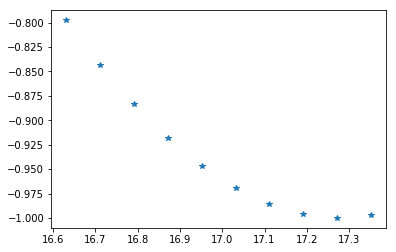

In [4]:
num_time_steps=10

y1,y2,ts= ts_data.next_batch(1,num_time_steps,True)

print(ts.flatten().shape)

plt.plot(ts.flatten()[:-1],y1.flatten(),"*")
plt.show()

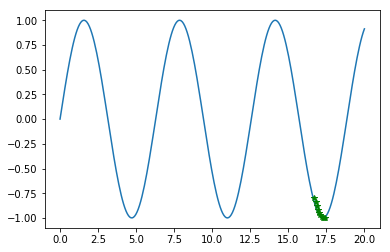

In [5]:
plt.plot(ts_data.x_data,ts_data.y_true)
plt.plot(ts.flatten()[1:],y1.flatten(),"g*")
plt.show()

In [6]:
num_inputs= num_time_steps
num_neurons=100
num_outputs=1
learning_rate=0.001
num_iter=5000
batch_size=1

x=tf.placeholder(tf.float32,[None,num_inputs,1])
y=tf.placeholder(tf.float32,[None,num_outputs])

# RNN output node weights and biases
weights = {
    'out': tf.Variable(tf.random_normal([num_neurons, num_outputs]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_outputs]))
}

In [7]:
def RNN(x, weights, biases):
    # 2-layer LSTM, each layer has n_hidden units.
    # Average Accuracy= 95.20% at 50k iter
    cell=tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(l_hidden),tf.contrib.rnn.BasicLSTMCell(num_neurons)], state_is_tuple=True)

    outputs,states=tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)

    # there are n_input outputs but
    # we only want the last output
    return  tf.matmul(outputs[-1], weights['out']) + biases['out']

In [8]:
#MSE
pred = RNN(x, weights, biases)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [22]:

loss=tf.reduce_mean(tf.square(pred-y))
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init=tf.global_variables_initializer()

train_inst=np.linspace(5,5+ts_data.resolution*(num_time_steps+1),num_time_steps+1)
x_new=np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,1)))

#If using GPU, specify the fraction oof memory to be consumed
#gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [24]:
with tf.Session() as sess:
    sess.run(init)
    
    for iter in range(num_iter):
        x_batch , y_batch = ts_data.next_batch(batch_size,num_time_steps)
        y_batch = [y_batch[-1][-1]]
        
        sess.run(optimizer,feed_dict={x:x_batch,y:y_batch})
        
        if iter %100==0:
        
            mse=loss.eval(feed_dict={x:x_batch,y:y_batch})
            print(iter, "\tMSE",mse)
            
        y_pred=sess.run(pred,feed_dict={x:x_new})

0 	MSE 0.15408123
100 	MSE 0.114303075
200 	MSE 0.055609692
300 	MSE 0.3181668
400 	MSE 0.28999954
500 	MSE 0.023177383
600 	MSE 0.061974943
700 	MSE 0.1626805
800 	MSE 0.21470165
900 	MSE 0.002983877
1000 	MSE 0.2221049
1100 	MSE 0.12609956
1200 	MSE 0.012192622
1300 	MSE 0.009665584
1400 	MSE 0.051148288
1500 	MSE 0.070213504
1600 	MSE 0.18138236
1700 	MSE 0.017657343
1800 	MSE 0.13615057
1900 	MSE 0.099289104
2000 	MSE 0.061965287
2100 	MSE 0.15774636
2200 	MSE 0.0105786985
2300 	MSE 0.053030826
2400 	MSE 0.025265899
2500 	MSE 0.09740557
2600 	MSE 0.071512625
2700 	MSE 0.037796043
2800 	MSE 0.037680514
2900 	MSE 0.016090786
3000 	MSE 0.0075222203
3100 	MSE 0.014832879
3200 	MSE 0.012188015
3300 	MSE 0.05399657
3400 	MSE 0.005578395
3500 	MSE 0.00022256638
3600 	MSE 0.03537356
3700 	MSE 0.03405037
3800 	MSE 0.042713504
3900 	MSE 0.050105326
4000 	MSE 0.067398176
4100 	MSE 0.01595027
4200 	MSE 0.020524874
4300 	MSE 0.053466387
4400 	MSE 0.011743673
4500 	MSE 0.015631232
4600 	MSE 0.02

In [ ]:
x_batch , y_batch = ts_data.next_batch(batch_size,num_time_steps)

In [ ]:
[y_batch[-1][-1]].shape

IndexError: too many indices for array

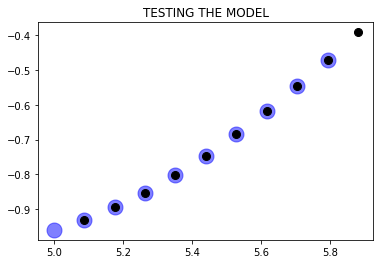

In [25]:
plt.title("TESTING THE MODEL")

#TRAINING INSTANCE
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=0.5,label="TRAINING INST")

#TARGET TO PREDICT 
plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize=8,label="TARGET")

#MODEL PREDCTION
plt.plot(train_inst[1:],y_pred[0,:,0],"r.",markersize=7,label="PREDICTIONS")

plt.xlabel("TIME")
plt.legend()
plt.tight_layout()

plt.show()